In [4]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [5]:
print(tf.__version__)

2.10.0


In [6]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [8]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [216]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .50)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [217]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [218]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, SMOTE




0    649
1     39
Name: binding, dtype: int64
0    73
1    39
Name: binding, dtype: int64


In [219]:
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    39
Name: binding, dtype: int64


In [220]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [221]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())

In [222]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [223]:
# smote = SMOTE(random_state=42)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [224]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [225]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [226]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [227]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [228]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .5 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [229]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .45:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [230]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.025)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [289]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = .00001 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [290]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  50.693374422187986
Epoch 1/60


2022-11-13 15:30:52.784389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8247 - tp: 175.0000 - fp: 85.0000 - tn: 235.0000 - fn: 154.0000 - precision: 0.6731 - recall: 0.5319

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5942275036572341
Recall TRAINING:  0.5319148898124695
10/10 [==============================] - 4s 197ms/step - loss: 5.8247 - tp: 175.0000 - fp: 85.0000 - tn: 235.0000 - fn: 154.0000 - precision: 0.6731 - recall: 0.5319



****** Early Stopping *******
17/41 [===========>..................] - ETA: 0s

2022-11-13 15:30:56.359417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.878213802435724
0.8613251155624037
error_rate: 0.00010683735318767058
0.9999999999999849
 =========== iteration ===========>: 1
bfore traning:  44.99229583975347
Epoch 1/60


2022-11-13 15:30:58.654213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 176ms/step - loss: 5.8458 - tp: 125.0000 - fp: 156.0000 - tn: 201.0000 - fn: 167.0000 - precision: 0.4448 - recall: 0.4281
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 1.5598 - tp: 282.0000 - fp: 64.0000 - tn: 293.0000 - fn: 10.0000 - precision: 0.8150 - recall: 0.9658

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8840125464058535
Recall TRAINING:  0.965753436088562
10/10 [==============================] - 0s 22ms/step - loss: 1.5598 - tp: 282.0000 - fp: 64.0000 - tn: 293.0000 - fn: 10.0000 - precision: 0.8150 - recall: 0.9658



****** Early Stopping *******
27/41 [==================>...........] - ETA: 0s

2022-11-13 15:31:02.110227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.9530102790014684
0.9506933744221879
error_rate: 3.79894504468831e-05
1.0000000000000002
 =========== iteration ===========>: 2
bfore traning:  47.76579352850539
Epoch 1/60


2022-11-13 15:31:02.785747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8417 - tp: 176.0000 - fp: 158.0000 - tn: 181.0000 - fn: 134.0000 - precision: 0.5269 - recall: 0.5677

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5465838591752882
Recall TRAINING:  0.5677419304847717
10/10 [==============================] - 3s 204ms/step - loss: 5.8417 - tp: 176.0000 - fp: 158.0000 - tn: 181.0000 - fn: 134.0000 - precision: 0.5269 - recall: 0.5677



****** Early Stopping *******
26/41 [==================>...........] - ETA: 0s

2022-11-13 15:31:05.834563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7953615279672579
0.7688751926040062
error_rate: 0.00017806810570464236
1.0000000000000164
 =========== iteration ===========>: 3
bfore traning:  50.53929121725732
Epoch 1/60


2022-11-13 15:31:06.447010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 204ms/step - loss: 5.8788 - tp: 81.0000 - fp: 31.0000 - tn: 290.0000 - fn: 247.0000 - precision: 0.7232 - recall: 0.2470
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 1.5828 - tp: 276.0000 - fp: 22.0000 - tn: 299.0000 - fn: 52.0000 - precision: 0.9262 - recall: 0.8415

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8817891661819951
Recall TRAINING:  0.8414634466171265
10/10 [==============================] - 0s 48ms/step - loss: 1.5828 - tp: 276.0000 - fp: 22.0000 - tn: 299.0000 - fn: 52.0000 - precision: 0.9262 - recall: 0.8415



****** Early Stopping *******
25/41 [=================>............] - ETA: 0s

2022-11-13 15:31:10.159477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.8791018998272885
0.8921417565485362
error_rate: 8.309089600072132e-05
1.0000000000000342
 =========== iteration ===========>: 4
bfore traning:  47.303543913713405
Epoch 1/60


2022-11-13 15:31:10.835566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 207ms/step - loss: 5.8424 - tp: 92.0000 - fp: 57.0000 - tn: 285.0000 - fn: 215.0000 - precision: 0.6174 - recall: 0.2997
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 1.5703 - tp: 259.0000 - fp: 4.0000 - tn: 338.0000 - fn: 48.0000 - precision: 0.9848 - recall: 0.8436

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9087719512455414
Recall TRAINING:  0.8436482548713684
10/10 [==============================] - 0s 23ms/step - loss: 1.5703 - tp: 259.0000 - fp: 4.0000 - tn: 338.0000 - fn: 48.0000 - precision: 0.9848 - recall: 0.8436



****** Early Stopping *******
16/41 [==========>...................] - ETA: 0s

2022-11-13 15:31:14.160794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.9860681114551084
0.9861325115562404
error_rate: 1.0685603563664963e-05
1.0000000000000047
 =========== iteration ===========>: 5
bfore traning:  50.38520801232666
Epoch 1/60


2022-11-13 15:31:14.804322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 202ms/step - loss: 5.8467 - tp: 137.0000 - fp: 124.0000 - tn: 198.0000 - fn: 190.0000 - precision: 0.5249 - recall: 0.4190
Epoch 2/60
10/10 [==============================] - ETA: 0s - loss: 1.5588 - tp: 316.0000 - fp: 104.0000 - tn: 218.0000 - fn: 11.0000 - precision: 0.7524 - recall: 0.9664

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8460508836003838
Recall TRAINING:  0.966360867023468
10/10 [==============================] - 0s 34ms/step - loss: 1.5588 - tp: 316.0000 - fp: 104.0000 - tn: 218.0000 - fn: 11.0000 - precision: 0.7524 - recall: 0.9664



****** Early Stopping *******
16/41 [==========>...................] - ETA: 0s

2022-11-13 15:31:18.404096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.8578982154659617
0.8343605546995377
error_rate: 0.00012762269593400775
0.999999999999986
 =========== iteration ===========>: 6
bfore traning:  49.61479198767334
Epoch 1/60


2022-11-13 15:31:19.042409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8331 - tp: 231.0000 - fp: 219.0000 - tn: 108.0000 - fn: 91.0000 - precision: 0.5133 - recall: 0.7174

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5984455899191002
Recall TRAINING:  0.717391312122345
10/10 [==============================] - 3s 184ms/step - loss: 5.8331 - tp: 231.0000 - fp: 219.0000 - tn: 108.0000 - fn: 91.0000 - precision: 0.5133 - recall: 0.7174



****** Early Stopping *******
28/41 [===================>..........] - ETA: 0s

2022-11-13 15:31:22.397442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7701612903225807
0.736517719568567
error_rate: 0.00020300205451058735
1.000000000000035
 =========== iteration ===========>: 7
bfore traning:  51.463790446841294
Epoch 1/60


2022-11-13 15:31:22.996300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8626 - tp: 288.0000 - fp: 192.0000 - tn: 123.0000 - fn: 46.0000 - precision: 0.6000 - recall: 0.8623

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7076167350137801
Recall TRAINING:  0.8622754812240601
10/10 [==============================] - 3s 162ms/step - loss: 5.8626 - tp: 288.0000 - fp: 192.0000 - tn: 123.0000 - fn: 46.0000 - precision: 0.6000 - recall: 0.8623



****** Early Stopping *******
36/41 [=========================>....] - ETA: 0s

2022-11-13 15:31:26.053156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.8358016741790084
0.8035439137134053
error_rate: 0.00015137543624668668
0.9999999999999862
 =========== iteration ===========>: 8
bfore traning:  53.46687211093991
Epoch 1/60


2022-11-13 15:31:26.640229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8219 - tp: 305.0000 - fp: 186.0000 - tn: 116.0000 - fn: 42.0000 - precision: 0.6212 - recall: 0.8790

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7279236734505186
Recall TRAINING:  0.8789625763893127
10/10 [==============================] - 3s 178ms/step - loss: 5.8219 - tp: 305.0000 - fp: 186.0000 - tn: 116.0000 - fn: 42.0000 - precision: 0.6212 - recall: 0.8790



****** Early Stopping *******
31/41 [=====================>........] - ETA: 0s

2022-11-13 15:31:29.406676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.7772455089820359
0.7134052388289677
error_rate: 0.00022083434607444706
0.9999999999999736
 =========== iteration ===========>: 9
bfore traning:  51.00154083204931
Epoch 1/60


2022-11-13 15:31:30.001531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8840 - tp: 193.0000 - fp: 105.0000 - tn: 213.0000 - fn: 138.0000 - precision: 0.6477 - recall: 0.5831

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6136724852558307
Recall TRAINING:  0.5830815434455872
10/10 [==============================] - 3s 179ms/step - loss: 5.8840 - tp: 193.0000 - fp: 105.0000 - tn: 213.0000 - fn: 138.0000 - precision: 0.6477 - recall: 0.5831



****** Early Stopping *******
30/41 [====================>.........] - ETA: 0s

2022-11-13 15:31:32.920907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step
0.8071570576540755
0.775808936825886
error_rate: 0.00017274616483780946
0.999999999999997
 =========== iteration ===========>: 10
bfore traning:  51.30970724191063
Epoch 1/60


2022-11-13 15:31:33.532080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8424 - tp: 285.0000 - fp: 249.0000 - tn: 67.0000 - fn: 48.0000 - precision: 0.5337 - recall: 0.8559

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6574394480324375
Recall TRAINING:  0.8558558821678162
10/10 [==============================] - 3s 190ms/step - loss: 5.8424 - tp: 285.0000 - fp: 249.0000 - tn: 67.0000 - fn: 48.0000 - precision: 0.5337 - recall: 0.8559



****** Early Stopping *******
28/41 [===================>..........] - ETA: 0s

2022-11-13 15:31:36.728054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.7612031921424187
0.7003081664098614
error_rate: 0.0002309358959171673
1.000000000000029
 =========== iteration ===========>: 11
bfore traning:  51.61787365177196
Epoch 1/60


2022-11-13 15:31:37.386290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.8466 - tp: 230.0000 - fp: 222.0000 - tn: 92.0000 - fn: 105.0000 - precision: 0.5088 - recall: 0.6866

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.584498104845863
Recall TRAINING:  0.6865671873092651
10/10 [==============================] - 3s 176ms/step - loss: 5.8466 - tp: 230.0000 - fp: 222.0000 - tn: 92.0000 - fn: 105.0000 - precision: 0.5088 - recall: 0.6866



****** Early Stopping *******
33/41 [=======================>......] - ETA: 0s

2022-11-13 15:31:40.431704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 4ms/step
0.6703221384509939
0.6294298921417566
error_rate: 0.00028551501770373043
1.0000000000000056


In [291]:
alphas

[9.144096100577156e-05,
 0.00010178164066428206,
 8.633166380571219e-05,
 9.39549232250082e-05,
 0.00011446602498121291,
 8.966304704208411e-05,
 8.502091435569676e-05,
 8.795596087306623e-05,
 8.417876844051458e-05,
 8.663514535125198e-05,
 8.373139430241005e-05,
 8.160930373052623e-05]

In [292]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [293]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [294]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    return score

In [295]:
f1_test = []
acc_test = []
for i in range(1,13):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    acc_test.append(accuracy_score(test_result, ans))

*********: 0
4/4 [==============================] - 0s 29ms/step
*********: 0
1/4 [======>.......................] - ETA: 0s

2022-11-13 15:31:46.654655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step
*********: 1
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 6ms/step


2022-11-13 15:31:46.895671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 9ms/step
*********: 2
4/4 [==============================] - 0s 22ms/step
*********: 0
4/4 [==============================] - 0s 4ms/step


2022-11-13 15:31:47.180777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 9ms/step
*********: 2
4/4 [==============================] - 0s 6ms/step
*********: 3
4/4 [==============================] - 0s 19ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-13 15:31:47.552462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 12ms/step
*********: 2
4/4 [==============================] - 0s 8ms/step
*********: 3
4/4 [==============================] - 0s 8ms/step
*********: 4
4/4 [==============================] - 0s 19ms/step
*********: 0
4/4 [==============================] - 0s 10ms/step


2022-11-13 15:31:47.948459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 7ms/step
*********: 3
4/4 [==============================] - 0s 7ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 21ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-13 15:31:48.396346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 4ms/step
*********: 2
4/4 [==============================] - 0s 4ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-13 15:31:48.836456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 4ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 7ms/step
*********: 4
4/4 [==============================] - 0s 7ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 15ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step


2022-11-13 15:31:49.359805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 7ms/step
*********: 4
4/4 [==============================] - 0s 14ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 8ms/step
*********: 7
4/4 [==============================] - 0s 13ms/step
*********: 8
4/4 [==============================] - 0s 28ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step


2022-11-13 15:31:50.017540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 6ms/step
*********: 5
4/4 [==============================] - 0s 7ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 6ms/step
*********: 8
4/4 [==============================] - 0s 7ms/step
*********: 9
4/4 [==============================] - 0s 18ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step


2022-11-13 15:31:50.676148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 8ms/step
*********: 8
4/4 [==============================] - 0s 12ms/step
*********: 9
4/4 [==============================] - 0s 10ms/step
*********: 10
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step


2022-11-13 15:31:51.338585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 4ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 7ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 9ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 8ms/step
*********: 11
4/4 [==============================] - 0s 21ms/step


2022-11-13 15:31:52.016497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [296]:
f1_train = []
acc_train = []
for i in range(1,13):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    acc_train.append(accuracy_score(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 5ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 4ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 4ms/step
*********:

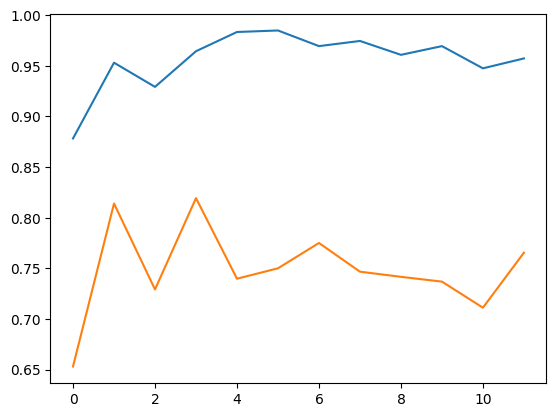

In [297]:
plt.plot(f1_train)
plt.plot(f1_test)

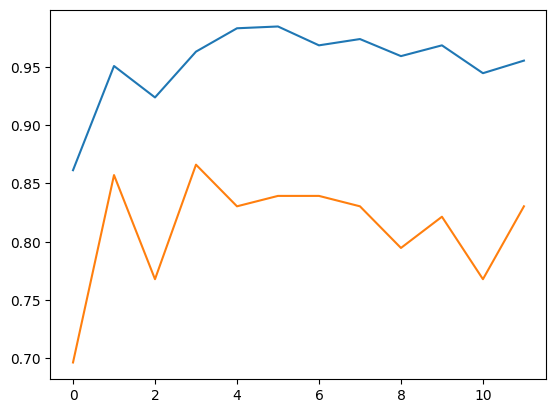

In [298]:
plt.plot(acc_train)
plt.plot(acc_test)

*********: 0
41/41 [==============================] - 0s 6ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 4ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 7ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step


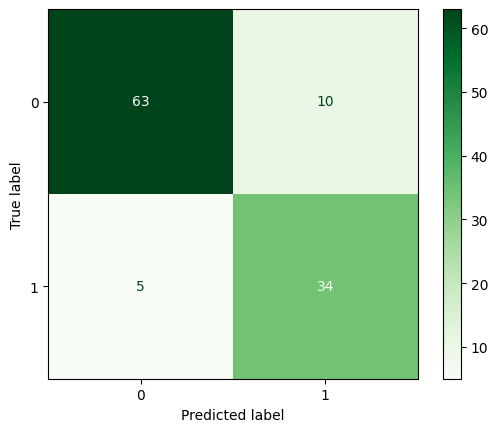

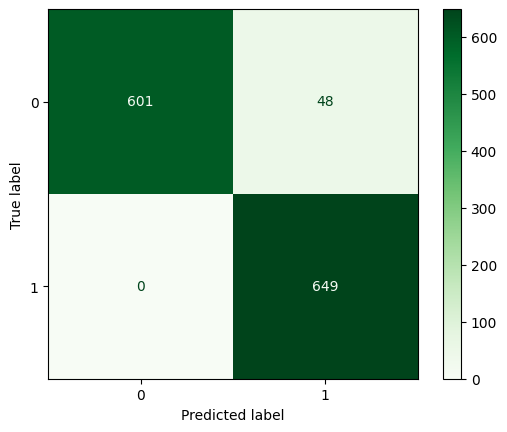

In [299]:
value = 4
data = some_pred(training_split, value)
ans = majority(data)
data = some_pred(test_split, value )
ans1 = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [300]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 4))

*********: 0
11/11 [==============================] - 0s 15ms/step
*********: 1
11/11 [==============================] - 0s 7ms/step
*********: 2
11/11 [==============================] - 0s 9ms/step
*********: 3
11/11 [==============================] - 0s 8ms/step


In [304]:
predicted_data
# len(predicted_data)


[1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
